In [1]:
import pandas as pd
import plotly
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import holidays
import yaml
import optuna
import json
import datetime
import logging
import sys
import os

from datetime import datetime
from prophet import Prophet
from prophet.diagnostics import cross_validation

config_path = r'../config/params.yml'
config = yaml.load(open(config_path), Loader=yaml.FullLoader)

model_path = config['train']['model_path']
params_path = config['train']['params_path']
backend_path = config['train']["backend_path"]
pred_days_forecast = config['train']['pred_days_forecast']
metrics_path = config['train']['metrics_path']
sys.path.append(backend_path)
from get_metrics import get_metrics

In [2]:
# Чтение DataFrame df в файл data/df.csv
df_path = config['preprocessing']['df_path']
df = pd.read_csv(df_path)

# Чтение DataFrame df_train в файл data/df_train.csv
train_path = config['preprocessing']['train_path']
df_train = pd.read_csv(train_path)

# Чтение DataFrame df_test в файл data/df_test.csv
test_path = config['preprocessing']['test_path']
df_test = pd.read_csv(test_path)

In [3]:
# Преобразование столбца ds в формат datetime
df['ds'] = pd.to_datetime(df['ds'], format='%Y-%m-%d', dayfirst=True)
df_train['ds'] = pd.to_datetime(df_train['ds'], format='%Y-%m-%d', dayfirst=True)
df_test['ds'] = pd.to_datetime(df_test['ds'], format='%Y-%m-%d', dayfirst=True)

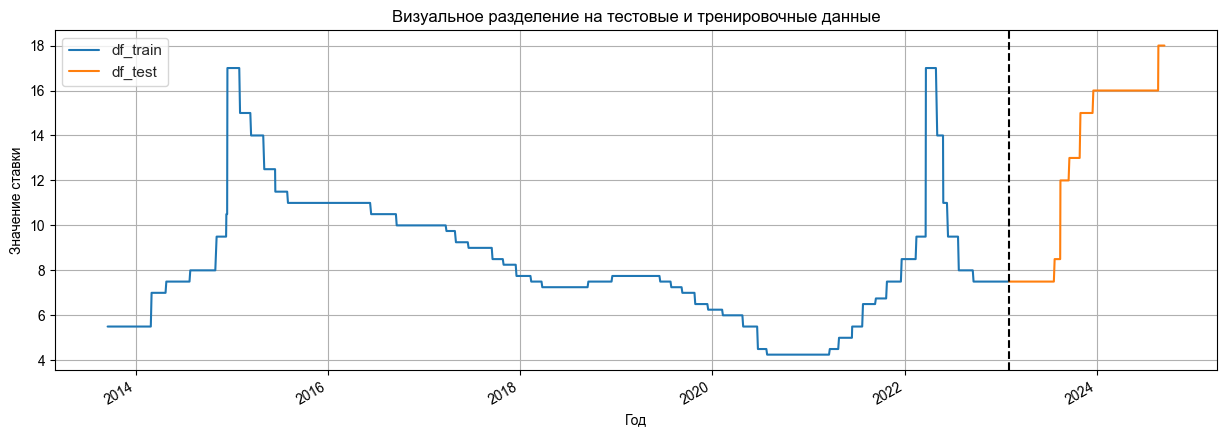

In [4]:
# Отображаем график с разделением train, test для наглядности
fig, ax = plt.subplots(figsize = (10, 5))

sns.set_theme(style="whitegrid", palette="Accent")

fig.set_figheight(5)
fig.set_figwidth(15)
df_train.set_index('ds').plot(ax=ax, label= 'train', title='Визуальное разделение на тестовые и тренировочные данные')
df_test.set_index('ds').plot(ax=ax, label='test')
ax.axvline(df_train['ds'][-1:].values, ls='--', color='black')
ax.legend(['df_train', 'df_test'])
ax.set_ylabel('Значение ставки')
ax.set_xlabel('Год')
plt.show()

In [5]:
# Период, который надо отрезать и предсказать (проверка модели)
pred_days = int(df.shape[0]*config['parcing']['pred_days'])

# Baseline Prophet on df_train для проверки модели

In [6]:
def train_model(df, **kwargs):
    """
    Обучение модели Prophet на данных.

    Аргументы:
        pandas.DataFrame: Данные для обучения с datetime и курсами.
        **kwargs: Параметры для модели Prophet.
    Возвращает: 
        Обученная модель.
    """
    model = Prophet(**kwargs)
    model.fit(df)
    return model

In [7]:
# Обучение модели на train
model_baseline = train_model(df_train)

01:19:35 - cmdstanpy - INFO - Chain [1] start processing
01:19:36 - cmdstanpy - INFO - Chain [1] done processing


In [8]:
def generate_forecast(model, pred_days):
    """
    Генерирует прогноз на заданное количество дней вперед.

    Параметры:
    - model: модель, используемая для прогнозирования
    - pred_days: количество дней, на которое нужно сделать прогноз

    Возвращает:
    - forecast: DataFrame с прогнозом
    """
    future = model.make_future_dataframe(periods=pred_days, freq='D')
    forecast = model.predict(future)
    return forecast

In [9]:
# Создание df с прогнозом
forecast = generate_forecast(model_baseline, pred_days)

In [10]:
def plot_forecast(model, forecast):
    """
    Отображает график прогноза и компоненты модели.

    Параметры:
    model (модель): Модель, использованная для прогнозирования.
    forecast (прогноз): Прогноз, полученный с помощью модели.

    Возвращает:
    None
    """

    FIGSIZE = (15, 5)
    # Смотрим график прогноза
    fig, ax = plt.subplots(1, figsize=FIGSIZE)
    model.plot(forecast, ax=ax)
    plt.show()

    # Смотрим тренд, годовые и сезонные признаки
    fig, ax = plt.subplots(1, figsize=FIGSIZE)
    model.plot_components(forecast)
    plt.show()

c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


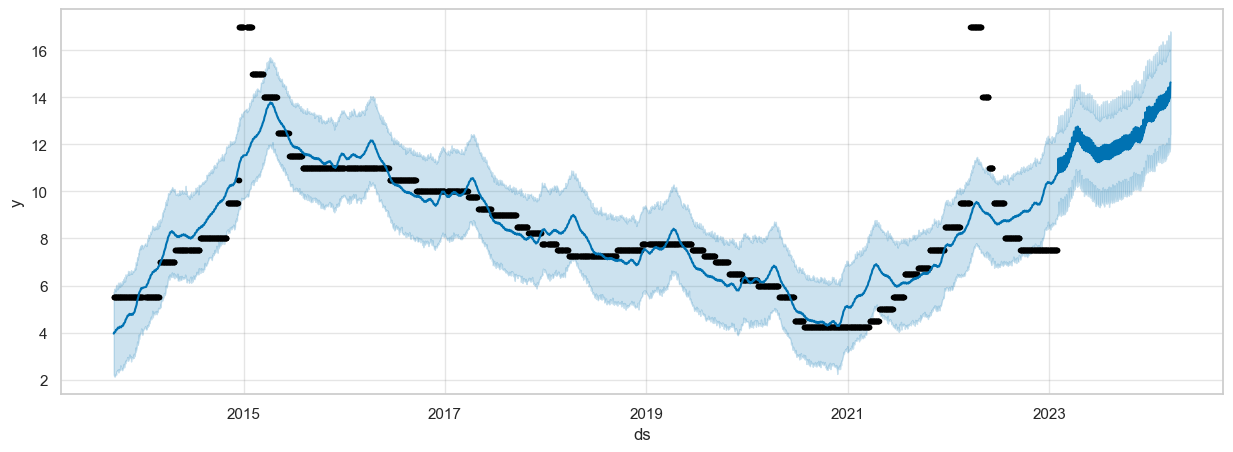

c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series cont

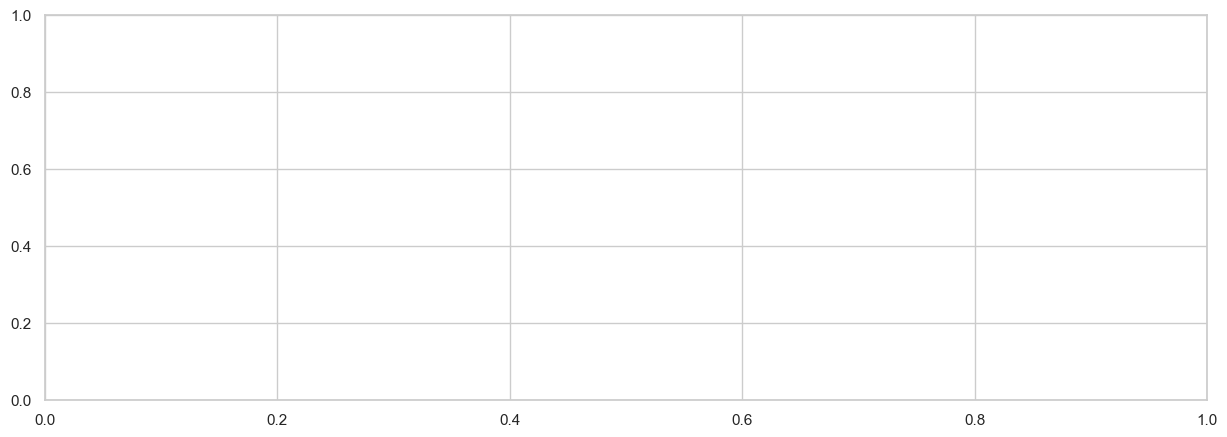

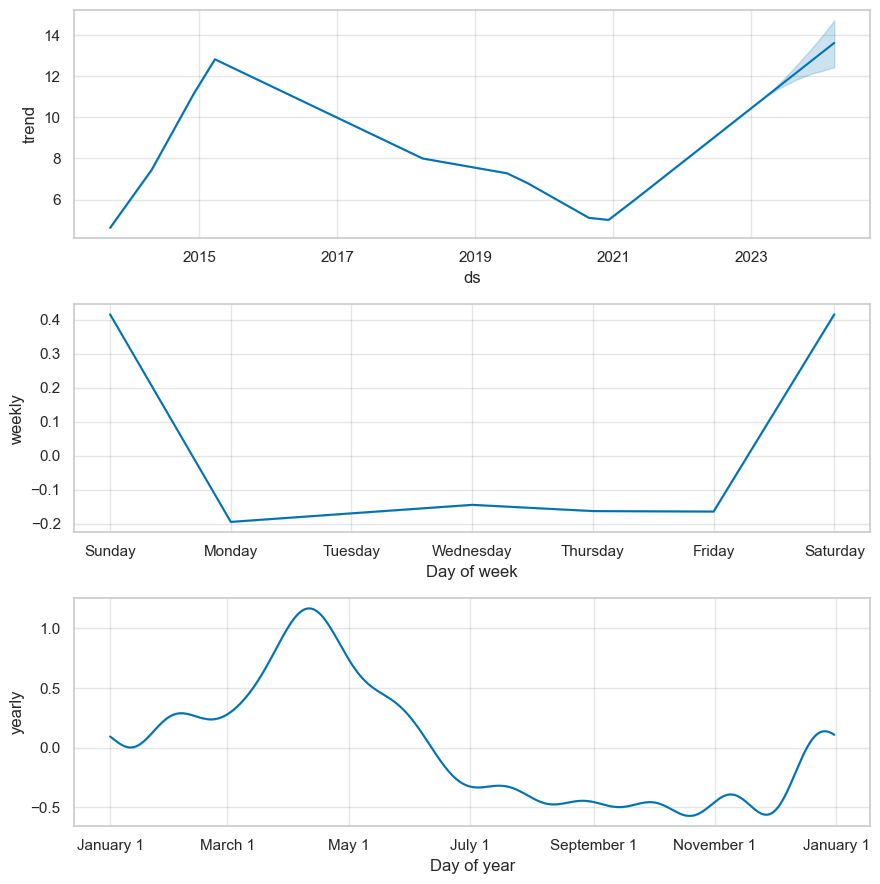

In [11]:
# Смотрим график прогноза, тренд, годовые и сезонные признаки
plot_forecast(model_baseline, forecast)

## Сравнение фактов и прогнозов

In [12]:
# Создание df с прогнозом
df_test_forecast = model_baseline.predict(df_test)
df_test_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
406,2024-09-09,14.223736,11.609543,16.924853
407,2024-09-10,14.253058,11.624012,16.996515
408,2024-09-11,14.282858,11.657798,17.019544
409,2024-09-12,14.270100,11.607460,16.948618
410,2024-09-13,14.275017,11.520941,16.827590


c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


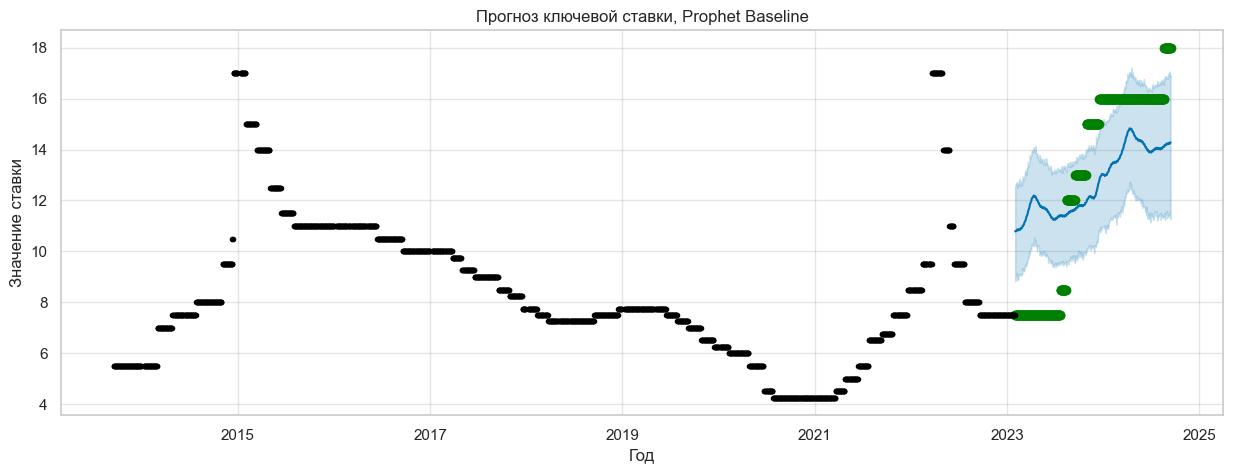

In [13]:
# Смотрим совпадение фактического курса с предсказанным курсом prophet baseline обученным на train
fig, ax = plt.subplots(figsize= (10, 5))

fig.set_figheight(5)
fig.set_figwidth(15)
predict = model_baseline.predict(df_test)
fig = model_baseline.plot(predict, ax=ax)
ax.scatter(df_test.ds, df_test['y'], color = 'g')
ax.set_title('Прогноз ключевой ставки, Prophet Baseline')
ax.set_ylabel('Значение ставки')
ax.set_xlabel('Год')
plt.show()

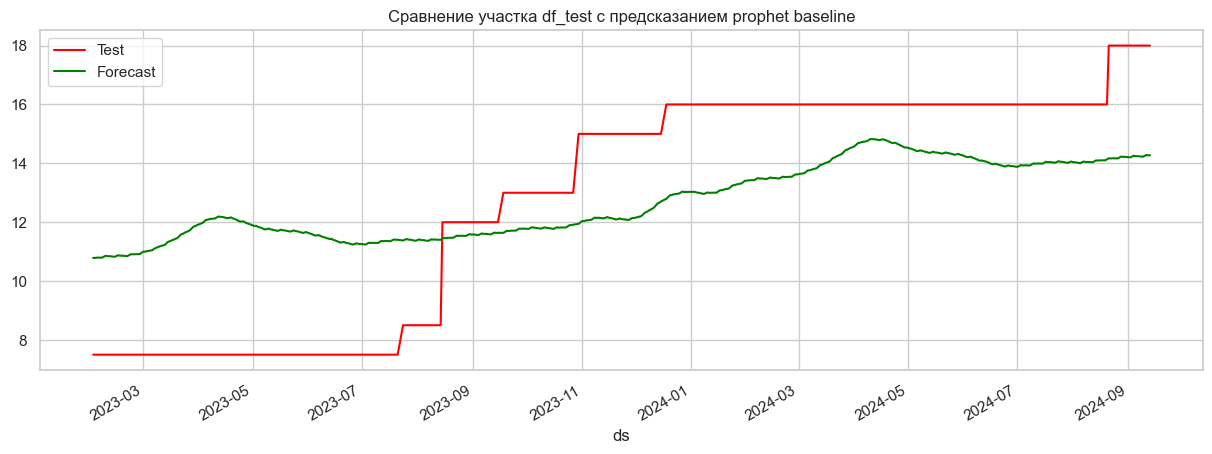

In [14]:
# Сравнение участка df_test с предсказанием prophet baseline
fig, ax = plt.subplots(figsize=(14,5))
fig.set_figheight(5)
fig.set_figwidth(15)
df_test.plot(kind='line',x='ds', y='y', color='red', label='Test', ax=ax)
df_test_forecast.plot(kind='line',x='ds',y='yhat', color='green',label='Forecast', ax=ax)
plt.title('Сравнение участка df_test с предсказанием prophet baseline')
plt.show()

In [15]:
# Просмотр метрик модели обученной на train
metrics = get_metrics(y_test=df_test['y'], y_pred=df_test_forecast['yhat'], name='Prophet_baseline')
metrics

,model,MAE,MAPE_%,MSE,RMSE
0,Prophet_baseline,2.63224,0.253425,8.240264,2.870586


Из приведенного выше графика мы видим, что существует разрыв в прогнозах и фактических данных. Поэтому нам нужно оптимизировать модель, добавив другие параметры, напрмиер, такие как праздники

# Prophet with holidays

In [16]:
# Создаем df праздников в РФ начиная с 2013 по сегодня
holiday = pd.DataFrame([])
for date, name in sorted(holidays.Russia(years=[2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024]).items()):
    new_row = pd.DataFrame({'ds': date, 'holiday': "RU-Holidays"}, index=[0])
    holiday = pd.concat([holiday, new_row], ignore_index=True)  

holiday['ds'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d', errors='ignore')

C:\Users\myxa-\AppData\Local\Temp\ipykernel_20368\3236026523.py:7: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  holiday['ds'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d', errors='ignore')


In [17]:
# Тренировка модели с праздниками
model_with_holidays = train_model(df_train, holidays=holiday)

01:19:39 - cmdstanpy - INFO - Chain [1] start processing
01:19:40 - cmdstanpy - INFO - Chain [1] done processing


In [18]:
# Создание df с прогнозом
forecast = generate_forecast(model_with_holidays, pred_days)

c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


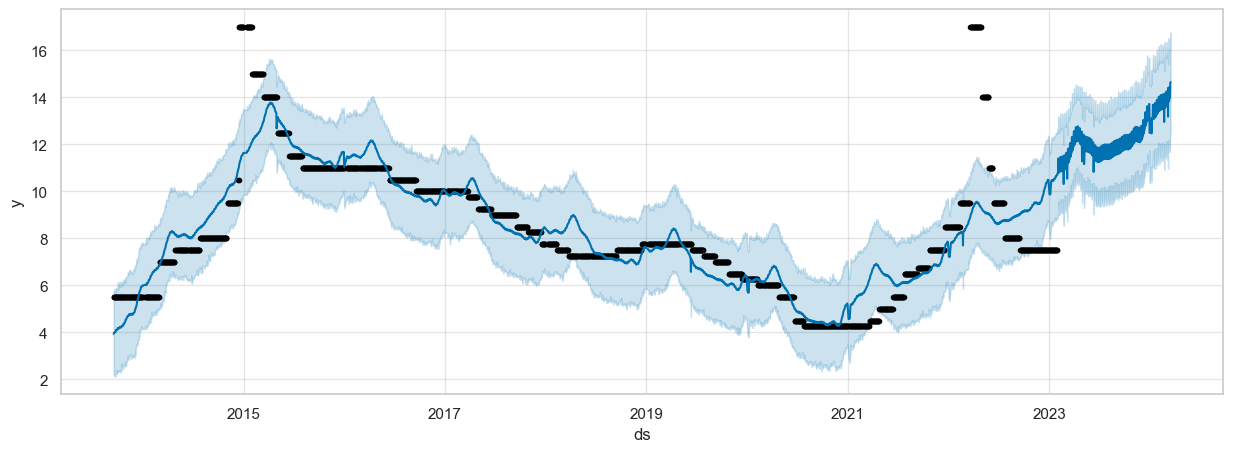

c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series cont

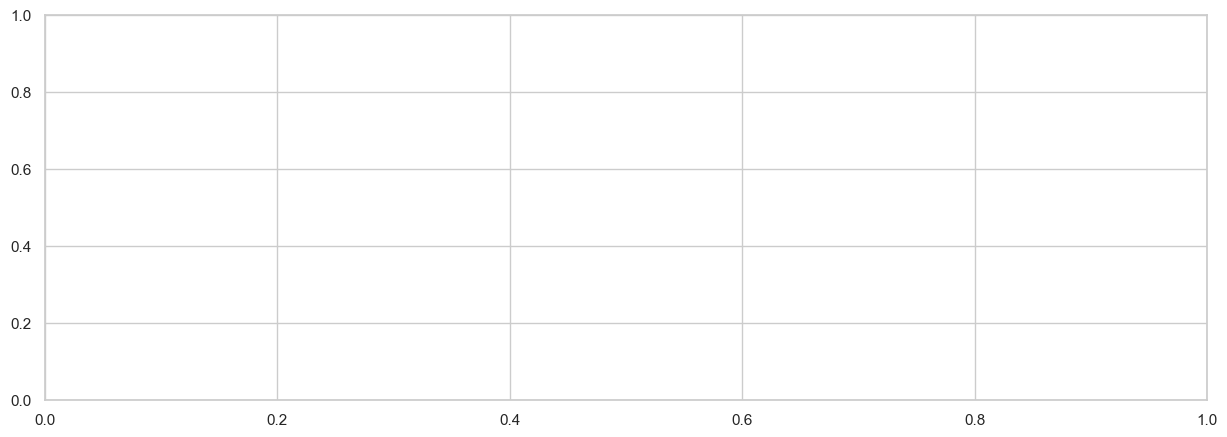

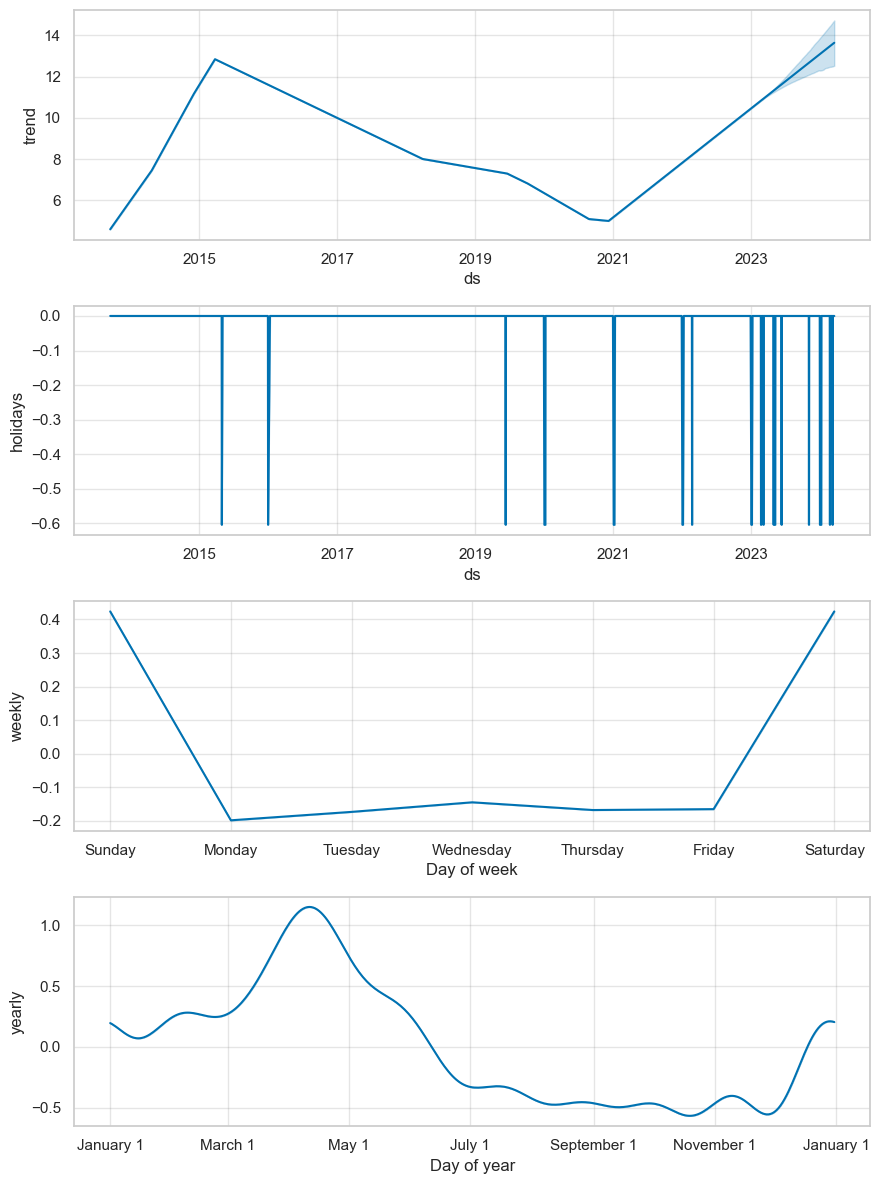

In [19]:
# Смотрим график прогноза, тренд, годовые и сезонные признаки обученной модели с праздниками
plot_forecast(model_with_holidays, forecast)

## Сравнение фактов и прогнозов

In [20]:
# Создание df с прогнозом
df_test_forecast_holiday = model_with_holidays.predict(df_test)
df_test_forecast_holiday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
406,2024-09-09,14.220614,11.288197,17.011701
407,2024-09-10,14.250661,11.294131,17.276267
408,2024-09-11,14.284665,11.426948,17.002021
409,2024-09-12,14.267776,11.470815,17.231225
410,2024-09-13,14.277131,11.537739,17.303530


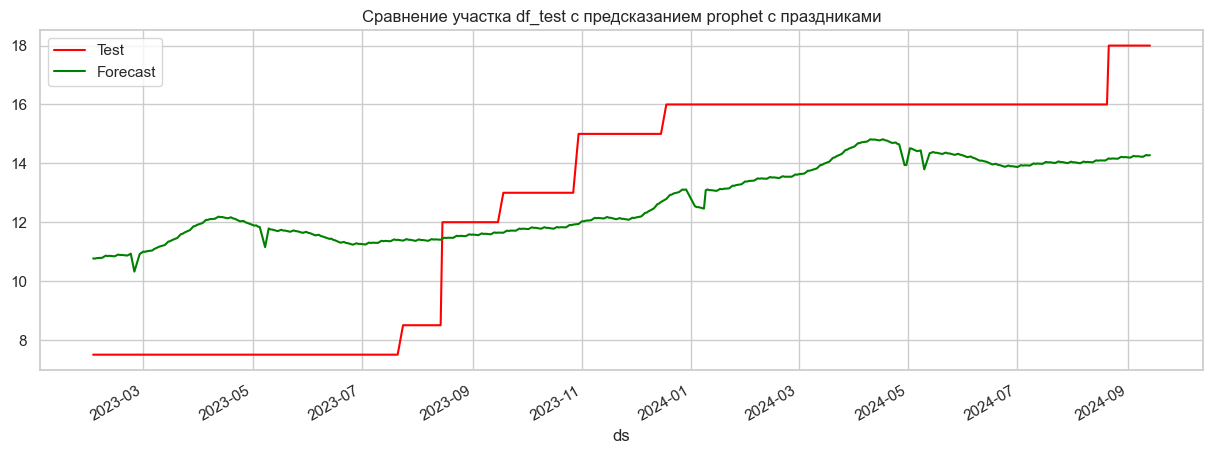

In [21]:
# Сравнение участка df_test с предсказанием prophet_with_holidays
fig, ax = plt.subplots(figsize=(14,5))
fig.set_figheight(5)
fig.set_figwidth(15)
df_test.plot(kind='line',x='ds', y='y', color='red', label='Test', ax=ax)
df_test_forecast_holiday.plot(kind='line',x='ds',y='yhat', color='green',label='Forecast', ax=ax)
plt.title('Сравнение участка df_test с предсказанием prophet с праздниками')
plt.show()

In [22]:
# Сравниваем метрики после добавления в модель праздников 
metrics = pd.concat([metrics, get_metrics(y_test=df_test['y'], y_pred=df_test_forecast_holiday['yhat'], name='Prophet_with_holidays')])
metrics

,model,MAE,MAPE_%,MSE,RMSE
0,Prophet_baseline,2.632240,0.253425,8.240264,2.870586
0,Prophet_with_holidays,2.638834,0.253672,8.267269,2.875286


Из метрик и графиков видим, что модель с праздниками показывает результаты немного изменились.

# Тюнинг тест модели

In [23]:
def optimize_prophet_hyperparameters(df_train, model_path, params_path, config):
    """
    Функция оптимизации гиперпараметров модели Prophet.

    Параметры:
    - df_train (pd.DataFrame): Данные для обучения модели.
    - model_path (str): Путь к директории, где будет сохранена лучшая модель.
    - params_path (str): Путь к директории, где будут сохранены лучшие параметры.
    - config (dict): Словарь с конфигурацией.

    Возвращает:
    - prophet_best_params (dict): Лучшие параметры модели Prophet.
    """

    # Определите целевую функцию для оптимизации
    def objective(trial):
        best_score = float('inf')
        # Гиперпараметры для настройки
        changepoint_prior_scale = trial.suggest_float('changepoint_prior_scale', 0.001, 0.5)
        seasonality_prior_scale = trial.suggest_float('seasonality_prior_scale', 0.01, 10)
        holidays_prior_scale = trial.suggest_float('holidays_prior_scale', 0.01, 10)
        seasonality_mode = trial.suggest_categorical('seasonality_mode', ['additive', 'multiplicative'])

        # Создайте модель Prophet с гиперпараметрами
        model = Prophet(changepoint_prior_scale=changepoint_prior_scale,
                        seasonality_prior_scale=seasonality_prior_scale,
                        holidays_prior_scale=holidays_prior_scale,
                        seasonality_mode=seasonality_mode,
                        )

        # Обучите модель
        model.fit(df_train)

        # Выполните кросс-валидацию
        cv_results = cross_validation(model, initial='730 days', period='180 days', horizon='30 days')

        # Расчет MAE
        mae = np.mean(np.abs(cv_results['y'] - cv_results['yhat']))

        score = mae

        # Обновляем best_score только если MAE лучше
        if score < best_score:
            best_score = score

        return score

    # Проверьте, существует ли сохраненная модель и лучшие параметры
    best_model_file = os.path.join(model_path, 'prophet_best_model.json')
    best_params_file = os.path.join(params_path, 'prophet_best_params.json')
    prophet_best_params = None
    if os.path.exists(best_model_file) and os.path.exists(best_params_file):
        print('Модель и параметры уже сохранены.')
        with open(best_model_file, 'r') as f:
            prophet_best_model = json.load(f)
        with open(best_params_file, 'r') as f:
            prophet_best_params = json.load(f)
        print('Лучшие параметры:', prophet_best_params)
    else:
        print('Модель или параметры не сохранены, выполняем поиск гиперпараметров')
        # Выполните поиск гиперпараметров с помощью Optuna
        study = optuna.create_study(direction='minimize')
        best_score = float('-inf')
        logging.getLogger('cmdstanpy').setLevel(logging.ERROR)
        study.optimize(objective, n_trials=config['train']['N_TRIALS'], timeout=config['train']['TIMEOUT'])
        prophet_best_params = study.best_params
        # Сохраните модель и лучшие параметры
        with open(best_model_file, 'w') as f:
            json.dump(prophet_best_params, f, indent=4)
        with open(best_params_file, 'w') as f:
            json.dump(study.best_params, f, indent=4)
        print('Модель и параметры сохранены')
        print('Лучшие параметры:', study.best_params)

    return prophet_best_params

In [24]:
# Обучение модели на лучших параметрах
prophet_best_params = optimize_prophet_hyperparameters(df_train, model_path, params_path, config)

[I 2024-09-15 01:19:42,701] A new study created in memory with name: no-name-17deaddf-4132-4933-968c-6a905db1baff


Модель или параметры не сохранены, выполняем поиск гиперпараметров


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2024-09-15 01:20:08,228] Trial 0 finished with value: 1.2392023516573207 and parameters: {'changepoint_prior_scale': 0.41318735416187813, 'seasonality_prior_scale': 2.525444044740031, 'holidays_prior_scale': 9.712243350228015, 'seasonality_mode': 'multiplicative'}. Best is trial 0 with value: 1.2392023516573207.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2024-09-15 01:20:32,125] Trial 1 finished with value: 1.2540713443715514 and parameters: {'changepoint_prior_scale': 0.43295638709098366, 'seasonality_prior_scale': 2.3655852201450362, 'holidays_prior_scale': 6.747977093843939, 'seasonality_mode': 'multiplicative'}. Best is trial 0 with value: 1.2392023516573207.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2024-09-15 01:20:54,040] Trial 2 finished with value: 1.1188772473627466 and parameters: {'changepoint_prior_scale': 0.010846284845415975, 'seasonality_prior_scale': 8.31044460131802, 'holidays_prior_scale': 6.081886021692065, 'seasonality_mode': 'multiplicative'}. Best is trial 2 with value: 1.1188772473627466.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2024-09-15 01:21:12,171] Trial 3 finished with value: 1.0728699290921098 and parameters: {'changepoint_prior_scale': 0.384127325929709, 'seasonality_prior_scale': 5.1721786076233345, 'holidays_prior_scale': 5.163934015683356, 'seasonality_mode': 'additive'}. Best is trial 3 with value: 1.0728699290921098.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2024-09-15 01:21:43,976] Trial 4 finished with value: 1.2144250935397847 and parameters: {'changepoint_prior_scale': 0.18736415892092756, 'seasonality_prior_scale': 5.704250562044986, 'holidays_prior_scale': 3.641726145309272, 'seasonality_mode': 'multiplicative'}. Best is trial 3 with value: 1.0728699290921098.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2024-09-15 01:22:01,815] Trial 5 finished with value: 1.0696202427275183 and parameters: {'changepoint_prior_scale': 0.3430797612442484, 'seasonality_prior_scale': 1.6611751873976806, 'holidays_prior_scale': 0.42924602916117355, 'seasonality_mode': 'additive'}. Best is trial 5 with value: 1.0696202427275183.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2024-09-15 01:22:34,578] Trial 6 finished with value: 1.201716283211466 and parameters: {'changepoint_prior_scale': 0.09512296593688616, 'seasonality_prior_scale': 4.510528302672689, 'holidays_prior_scale': 3.114512685774319, 'seasonality_mode': 'multiplicative'}. Best is trial 5 with value: 1.0696202427275183.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2024-09-15 01:23:05,700] Trial 7 finished with value: 1.2140841332728192 and parameters: {'changepoint_prior_scale': 0.1856410129975605, 'seasonality_prior_scale': 5.597811365244127, 'holidays_prior_scale': 6.8975981494924365, 'seasonality_mode': 'multiplicative'}. Best is trial 5 with value: 1.0696202427275183.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2024-09-15 01:23:39,318] Trial 8 finished with value: 1.188672983621991 and parameters: {'changepoint_prior_scale': 0.09192432831497449, 'seasonality_prior_scale': 9.068554986715165, 'holidays_prior_scale': 4.882177082913817, 'seasonality_mode': 'multiplicative'}. Best is trial 5 with value: 1.0696202427275183.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2024-09-15 01:24:03,870] Trial 9 finished with value: 1.2417150504720544 and parameters: {'changepoint_prior_scale': 0.39358296551609256, 'seasonality_prior_scale': 1.3367353250927243, 'holidays_prior_scale': 8.906504434149484, 'seasonality_mode': 'multiplicative'}. Best is trial 5 with value: 1.0696202427275183.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2024-09-15 01:24:21,851] Trial 10 finished with value: 1.0756014980707114 and parameters: {'changepoint_prior_scale': 0.3025113689242971, 'seasonality_prior_scale': 0.3115791235094836, 'holidays_prior_scale': 0.9716174153833859, 'seasonality_mode': 'additive'}. Best is trial 5 with value: 1.0696202427275183.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2024-09-15 01:24:38,798] Trial 11 finished with value: 1.0695253791658392 and parameters: {'changepoint_prior_scale': 0.31458394549237145, 'seasonality_prior_scale': 3.721865764521532, 'holidays_prior_scale': 1.18558933691609, 'seasonality_mode': 'additive'}. Best is trial 11 with value: 1.0695253791658392.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2024-09-15 01:24:56,417] Trial 12 finished with value: 1.0788280897625264 and parameters: {'changepoint_prior_scale': 0.2870408147382928, 'seasonality_prior_scale': 3.4628360473985493, 'holidays_prior_scale': 0.06199546544028589, 'seasonality_mode': 'additive'}. Best is trial 11 with value: 1.0695253791658392.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2024-09-15 01:25:15,347] Trial 13 finished with value: 1.075102152938027 and parameters: {'changepoint_prior_scale': 0.4993211800406274, 'seasonality_prior_scale': 0.14851450616780593, 'holidays_prior_scale': 1.8568160267939755, 'seasonality_mode': 'additive'}. Best is trial 11 with value: 1.0695253791658392.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2024-09-15 01:25:33,243] Trial 14 finished with value: 1.0727628160525435 and parameters: {'changepoint_prior_scale': 0.30940001314082544, 'seasonality_prior_scale': 7.492904786827475, 'holidays_prior_scale': 2.018872433759184, 'seasonality_mode': 'additive'}. Best is trial 11 with value: 1.0695253791658392.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2024-09-15 01:25:50,460] Trial 15 finished with value: 1.0860531384671526 and parameters: {'changepoint_prior_scale': 0.22451952397481317, 'seasonality_prior_scale': 3.4131354046978672, 'holidays_prior_scale': 0.7511857742335641, 'seasonality_mode': 'additive'}. Best is trial 11 with value: 1.0695253791658392.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2024-09-15 01:26:09,215] Trial 16 finished with value: 1.0703239866761478 and parameters: {'changepoint_prior_scale': 0.3458740846165309, 'seasonality_prior_scale': 1.644662860634907, 'holidays_prior_scale': 3.155362267363633, 'seasonality_mode': 'additive'}. Best is trial 11 with value: 1.0695253791658392.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2024-09-15 01:26:28,489] Trial 17 finished with value: 1.077151401625227 and parameters: {'changepoint_prior_scale': 0.4918402207273719, 'seasonality_prior_scale': 6.652855484636987, 'holidays_prior_scale': 1.5905551897285424, 'seasonality_mode': 'additive'}. Best is trial 11 with value: 1.0695253791658392.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2024-09-15 01:26:46,007] Trial 18 finished with value: 1.0757118751010113 and parameters: {'changepoint_prior_scale': 0.25688596650604983, 'seasonality_prior_scale': 3.863196165772464, 'holidays_prior_scale': 0.29199451189054537, 'seasonality_mode': 'additive'}. Best is trial 11 with value: 1.0695253791658392.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2024-09-15 01:27:03,175] Trial 19 finished with value: 1.0697055823271593 and parameters: {'changepoint_prior_scale': 0.34858260448915307, 'seasonality_prior_scale': 1.4663068948234224, 'holidays_prior_scale': 2.518088157725308, 'seasonality_mode': 'additive'}. Best is trial 11 with value: 1.0695253791658392.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2024-09-15 01:27:20,020] Trial 20 finished with value: 1.0812392667401935 and parameters: {'changepoint_prior_scale': 0.21938292143532068, 'seasonality_prior_scale': 9.93884325904756, 'holidays_prior_scale': 4.276298727241536, 'seasonality_mode': 'additive'}. Best is trial 11 with value: 1.0695253791658392.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2024-09-15 01:27:37,583] Trial 21 finished with value: 1.0688191942965473 and parameters: {'changepoint_prior_scale': 0.3475673330107894, 'seasonality_prior_scale': 1.3359746675555195, 'holidays_prior_scale': 2.41101657511383, 'seasonality_mode': 'additive'}. Best is trial 21 with value: 1.0688191942965473.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2024-09-15 01:27:55,678] Trial 22 finished with value: 1.0695938953248814 and parameters: {'changepoint_prior_scale': 0.3459112934583345, 'seasonality_prior_scale': 2.3772571568466443, 'holidays_prior_scale': 1.2674407419802618, 'seasonality_mode': 'additive'}. Best is trial 21 with value: 1.0688191942965473.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2024-09-15 01:28:13,531] Trial 23 finished with value: 1.0745138245218835 and parameters: {'changepoint_prior_scale': 0.4462209959340969, 'seasonality_prior_scale': 2.8475014321780856, 'holidays_prior_scale': 1.570975954595541, 'seasonality_mode': 'additive'}. Best is trial 21 with value: 1.0688191942965473.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2024-09-15 01:28:30,876] Trial 24 finished with value: 1.0734916863373614 and parameters: {'changepoint_prior_scale': 0.2810877202274918, 'seasonality_prior_scale': 4.386875157977881, 'holidays_prior_scale': 2.4379807075414703, 'seasonality_mode': 'additive'}. Best is trial 21 with value: 1.0688191942965473.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2024-09-15 01:28:48,539] Trial 25 finished with value: 1.071358420258072 and parameters: {'changepoint_prior_scale': 0.3671361676232627, 'seasonality_prior_scale': 0.6306854192482074, 'holidays_prior_scale': 1.1740404448801962, 'seasonality_mode': 'additive'}. Best is trial 21 with value: 1.0688191942965473.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2024-09-15 01:29:06,709] Trial 26 finished with value: 1.0713683834399388 and parameters: {'changepoint_prior_scale': 0.3288539040930822, 'seasonality_prior_scale': 2.450113283395309, 'holidays_prior_scale': 3.804488517048804, 'seasonality_mode': 'additive'}. Best is trial 21 with value: 1.0688191942965473.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2024-09-15 01:29:25,031] Trial 27 finished with value: 1.0760550898534853 and parameters: {'changepoint_prior_scale': 0.45316799001983393, 'seasonality_prior_scale': 1.002682847010008, 'holidays_prior_scale': 2.628291930725444, 'seasonality_mode': 'additive'}. Best is trial 21 with value: 1.0688191942965473.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2024-09-15 01:29:42,501] Trial 28 finished with value: 1.0778129276629371 and parameters: {'changepoint_prior_scale': 0.261020569191492, 'seasonality_prior_scale': 3.164453237021141, 'holidays_prior_scale': 1.1259731321397777, 'seasonality_mode': 'additive'}. Best is trial 21 with value: 1.0688191942965473.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2024-09-15 01:30:00,736] Trial 29 finished with value: 1.0715809082146934 and parameters: {'changepoint_prior_scale': 0.4108860555554226, 'seasonality_prior_scale': 2.0290768565737873, 'holidays_prior_scale': 3.0933241883775375, 'seasonality_mode': 'additive'}. Best is trial 21 with value: 1.0688191942965473.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2024-09-15 01:30:19,297] Trial 30 finished with value: 1.0711605720295034 and parameters: {'changepoint_prior_scale': 0.38281414914879425, 'seasonality_prior_scale': 4.127306209284155, 'holidays_prior_scale': 9.006623073916572, 'seasonality_mode': 'additive'}. Best is trial 21 with value: 1.0688191942965473.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2024-09-15 01:30:36,568] Trial 31 finished with value: 1.073507003279923 and parameters: {'changepoint_prior_scale': 0.3348035310934138, 'seasonality_prior_scale': 2.005870739011275, 'holidays_prior_scale': 0.30812393037413244, 'seasonality_mode': 'additive'}. Best is trial 21 with value: 1.0688191942965473.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2024-09-15 01:30:53,828] Trial 32 finished with value: 1.0927606623195203 and parameters: {'changepoint_prior_scale': 0.31173309363738344, 'seasonality_prior_scale': 2.7115836535881814, 'holidays_prior_scale': 0.6197257913619633, 'seasonality_mode': 'additive'}. Best is trial 21 with value: 1.0688191942965473.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2024-09-15 01:31:11,654] Trial 33 finished with value: 1.0719611711360677 and parameters: {'changepoint_prior_scale': 0.35258170654158, 'seasonality_prior_scale': 2.1243855617231118, 'holidays_prior_scale': 1.4491795837944819, 'seasonality_mode': 'additive'}. Best is trial 21 with value: 1.0688191942965473.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2024-09-15 01:31:29,798] Trial 34 finished with value: 1.0725458966068728 and parameters: {'changepoint_prior_scale': 0.4162147970442517, 'seasonality_prior_scale': 0.8990147517309892, 'holidays_prior_scale': 2.115477609036765, 'seasonality_mode': 'additive'}. Best is trial 21 with value: 1.0688191942965473.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2024-09-15 01:31:46,934] Trial 35 finished with value: 1.072879787281123 and parameters: {'changepoint_prior_scale': 0.22923045244300144, 'seasonality_prior_scale': 2.7812057241801598, 'holidays_prior_scale': 0.7299839117087545, 'seasonality_mode': 'additive'}. Best is trial 21 with value: 1.0688191942965473.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2024-09-15 01:32:16,929] Trial 36 finished with value: 1.22545268688333 and parameters: {'changepoint_prior_scale': 0.2776079243196935, 'seasonality_prior_scale': 5.125114941261348, 'holidays_prior_scale': 6.130174769380417, 'seasonality_mode': 'multiplicative'}. Best is trial 21 with value: 1.0688191942965473.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2024-09-15 01:32:34,647] Trial 37 finished with value: 1.071485806544617 and parameters: {'changepoint_prior_scale': 0.3750170159956956, 'seasonality_prior_scale': 1.723356693484504, 'holidays_prior_scale': 0.05668438026925138, 'seasonality_mode': 'additive'}. Best is trial 21 with value: 1.0688191942965473.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2024-09-15 01:32:59,395] Trial 38 finished with value: 1.2235731636551386 and parameters: {'changepoint_prior_scale': 0.18875500453555435, 'seasonality_prior_scale': 1.1774535439246436, 'holidays_prior_scale': 4.527140661121565, 'seasonality_mode': 'multiplicative'}. Best is trial 21 with value: 1.0688191942965473.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2024-09-15 01:33:17,737] Trial 39 finished with value: 1.077816687871112 and parameters: {'changepoint_prior_scale': 0.4646814012919722, 'seasonality_prior_scale': 3.761988650601341, 'holidays_prior_scale': 3.5941524904538236, 'seasonality_mode': 'additive'}. Best is trial 21 with value: 1.0688191942965473.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2024-09-15 01:33:43,603] Trial 40 finished with value: 1.2345893483613288 and parameters: {'changepoint_prior_scale': 0.4162814473806279, 'seasonality_prior_scale': 4.595432459251006, 'holidays_prior_scale': 7.703755240835006, 'seasonality_mode': 'multiplicative'}. Best is trial 21 with value: 1.0688191942965473.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2024-09-15 01:34:01,063] Trial 41 finished with value: 1.0711465481883446 and parameters: {'changepoint_prior_scale': 0.33009251082785157, 'seasonality_prior_scale': 1.5051839005636958, 'holidays_prior_scale': 2.5602249441675546, 'seasonality_mode': 'additive'}. Best is trial 21 with value: 1.0688191942965473.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2024-09-15 01:34:19,366] Trial 42 finished with value: 1.0712875349714568 and parameters: {'changepoint_prior_scale': 0.357153311016845, 'seasonality_prior_scale': 0.3606189475590136, 'holidays_prior_scale': 2.2673599276089216, 'seasonality_mode': 'additive'}. Best is trial 21 with value: 1.0688191942965473.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2024-09-15 01:34:37,585] Trial 43 finished with value: 1.077152113982034 and parameters: {'changepoint_prior_scale': 0.3946003904876154, 'seasonality_prior_scale': 2.402350641405355, 'holidays_prior_scale': 2.9125187610746406, 'seasonality_mode': 'additive'}. Best is trial 21 with value: 1.0688191942965473.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2024-09-15 01:34:55,950] Trial 44 finished with value: 1.0720762957531764 and parameters: {'changepoint_prior_scale': 0.3072062668100699, 'seasonality_prior_scale': 3.120229428587149, 'holidays_prior_scale': 1.7329967660976493, 'seasonality_mode': 'additive'}. Best is trial 21 with value: 1.0688191942965473.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2024-09-15 01:35:13,099] Trial 45 finished with value: 1.070634657061216 and parameters: {'changepoint_prior_scale': 0.3273760721892661, 'seasonality_prior_scale': 0.7173535343820927, 'holidays_prior_scale': 0.9697763458174494, 'seasonality_mode': 'additive'}. Best is trial 21 with value: 1.0688191942965473.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2024-09-15 01:35:42,626] Trial 46 finished with value: 1.2313655641167591 and parameters: {'changepoint_prior_scale': 0.0694136617148497, 'seasonality_prior_scale': 1.3833737537795259, 'holidays_prior_scale': 1.1981024499623079, 'seasonality_mode': 'multiplicative'}. Best is trial 21 with value: 1.0688191942965473.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2024-09-15 01:36:01,564] Trial 47 finished with value: 1.0703804101674654 and parameters: {'changepoint_prior_scale': 0.2984463520236425, 'seasonality_prior_scale': 6.1516208511450525, 'holidays_prior_scale': 3.52881115313422, 'seasonality_mode': 'additive'}. Best is trial 21 with value: 1.0688191942965473.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2024-09-15 01:36:19,050] Trial 48 finished with value: 1.0719167462300354 and parameters: {'changepoint_prior_scale': 0.3568539582092485, 'seasonality_prior_scale': 0.09989619194830768, 'holidays_prior_scale': 5.531042199216081, 'seasonality_mode': 'additive'}. Best is trial 21 with value: 1.0688191942965473.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2024-09-15 01:36:36,136] Trial 49 finished with value: 1.07309317276964 and parameters: {'changepoint_prior_scale': 0.3997601867908191, 'seasonality_prior_scale': 1.887758658406443, 'holidays_prior_scale': 1.923165610356586, 'seasonality_mode': 'additive'}. Best is trial 21 with value: 1.0688191942965473.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2024-09-15 01:36:54,213] Trial 50 finished with value: 1.0721896983082195 and parameters: {'changepoint_prior_scale': 0.4315077323870824, 'seasonality_prior_scale': 3.4533195529290377, 'holidays_prior_scale': 0.483457315880488, 'seasonality_mode': 'additive'}. Best is trial 21 with value: 1.0688191942965473.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2024-09-15 01:37:11,571] Trial 51 finished with value: 1.0683521397687246 and parameters: {'changepoint_prior_scale': 0.3454689738679083, 'seasonality_prior_scale': 1.659963193154061, 'holidays_prior_scale': 2.9802330031242183, 'seasonality_mode': 'additive'}. Best is trial 51 with value: 1.0683521397687246.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2024-09-15 01:37:28,973] Trial 52 finished with value: 1.0704036631371543 and parameters: {'changepoint_prior_scale': 0.37865616304922484, 'seasonality_prior_scale': 1.3556950757819044, 'holidays_prior_scale': 2.9364291636725692, 'seasonality_mode': 'additive'}. Best is trial 51 with value: 1.0683521397687246.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2024-09-15 01:37:47,005] Trial 53 finished with value: 1.0675927736069104 and parameters: {'changepoint_prior_scale': 0.3442716632961486, 'seasonality_prior_scale': 2.3139381463064703, 'holidays_prior_scale': 1.4729215399259428, 'seasonality_mode': 'additive'}. Best is trial 53 with value: 1.0675927736069104.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2024-09-15 01:38:04,776] Trial 54 finished with value: 1.0750718820147633 and parameters: {'changepoint_prior_scale': 0.2710551835319599, 'seasonality_prior_scale': 2.3852845090131614, 'holidays_prior_scale': 1.4218392986309363, 'seasonality_mode': 'additive'}. Best is trial 53 with value: 1.0675927736069104.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2024-09-15 01:38:21,192] Trial 55 finished with value: 1.0734222201471588 and parameters: {'changepoint_prior_scale': 0.24253803402684257, 'seasonality_prior_scale': 3.0787813899336642, 'holidays_prior_scale': 2.0686084958888347, 'seasonality_mode': 'additive'}. Best is trial 53 with value: 1.0675927736069104.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2024-09-15 01:38:38,852] Trial 56 finished with value: 1.0731013933780627 and parameters: {'changepoint_prior_scale': 0.30980958686845234, 'seasonality_prior_scale': 3.8126872771788394, 'holidays_prior_scale': 0.914803383713489, 'seasonality_mode': 'additive'}. Best is trial 53 with value: 1.0675927736069104.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2024-09-15 01:38:58,485] Trial 57 finished with value: 1.231630031068146 and parameters: {'changepoint_prior_scale': 0.2887938843937003, 'seasonality_prior_scale': 0.505570288312124, 'holidays_prior_scale': 1.6488836582205362, 'seasonality_mode': 'multiplicative'}. Best is trial 53 with value: 1.0675927736069104.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2024-09-15 01:39:17,076] Trial 58 finished with value: 1.0699832707686652 and parameters: {'changepoint_prior_scale': 0.3216583836359187, 'seasonality_prior_scale': 2.1502191211608315, 'holidays_prior_scale': 0.31758793012250086, 'seasonality_mode': 'additive'}. Best is trial 53 with value: 1.0675927736069104.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2024-09-15 01:39:35,145] Trial 59 finished with value: 1.0696192398665498 and parameters: {'changepoint_prior_scale': 0.33736472994327443, 'seasonality_prior_scale': 0.9980215769278025, 'holidays_prior_scale': 4.014623015783039, 'seasonality_mode': 'additive'}. Best is trial 53 with value: 1.0675927736069104.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2024-09-15 01:39:52,708] Trial 60 finished with value: 1.0703587133978243 and parameters: {'changepoint_prior_scale': 0.34367567141357325, 'seasonality_prior_scale': 1.6723200134114655, 'holidays_prior_scale': 4.098423289813065, 'seasonality_mode': 'additive'}. Best is trial 53 with value: 1.0675927736069104.


Модель и параметры сохранены
Лучшие параметры: {'changepoint_prior_scale': 0.3442716632961486, 'seasonality_prior_scale': 2.3139381463064703, 'holidays_prior_scale': 1.4729215399259428, 'seasonality_mode': 'additive'}


## Лучшие параметры после обучения по сетке

In [25]:
# Обучение модели на лучших параметрах
final_test_model = train_model(df_train, **prophet_best_params)

In [26]:
# Создание df с прогнозом
forecast = generate_forecast(final_test_model, pred_days)

c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


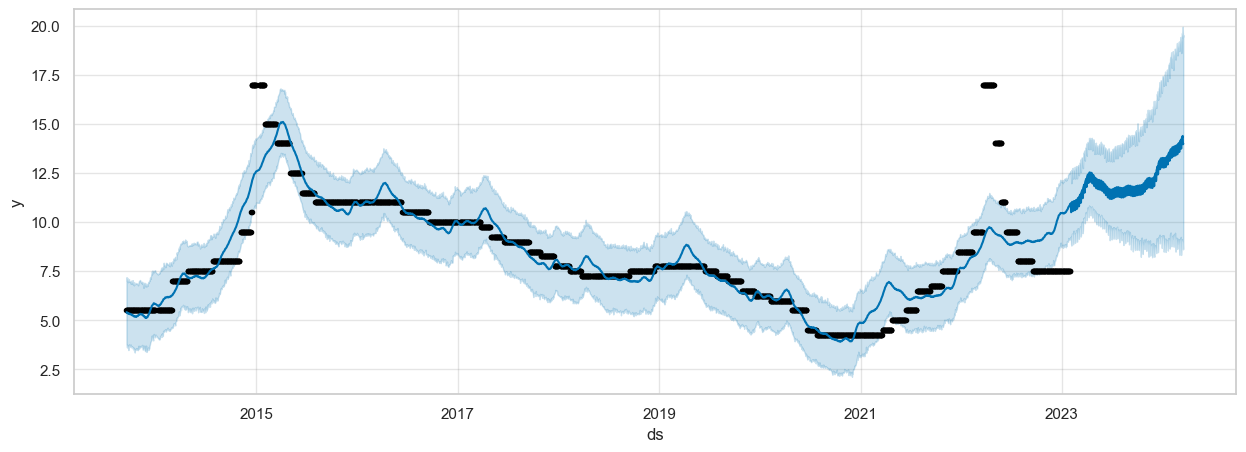

c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series cont

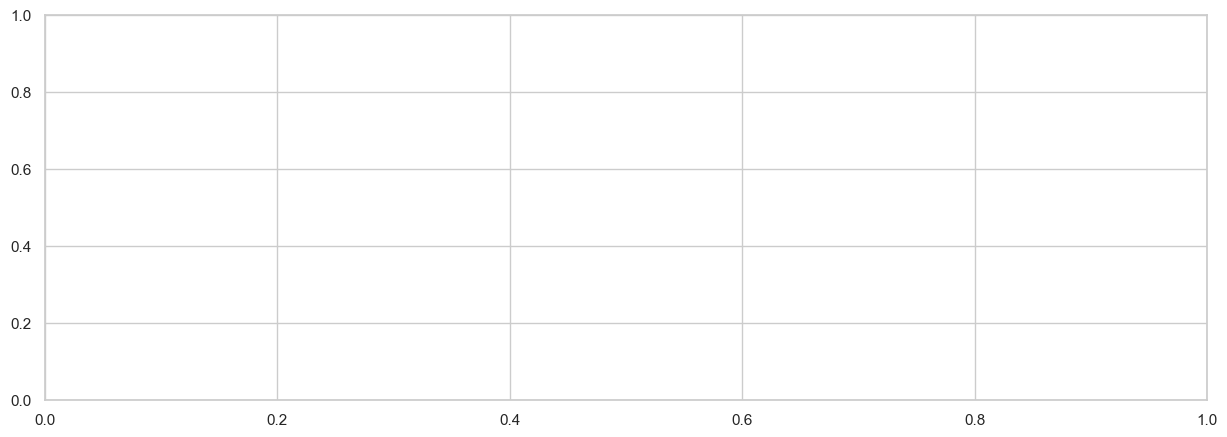

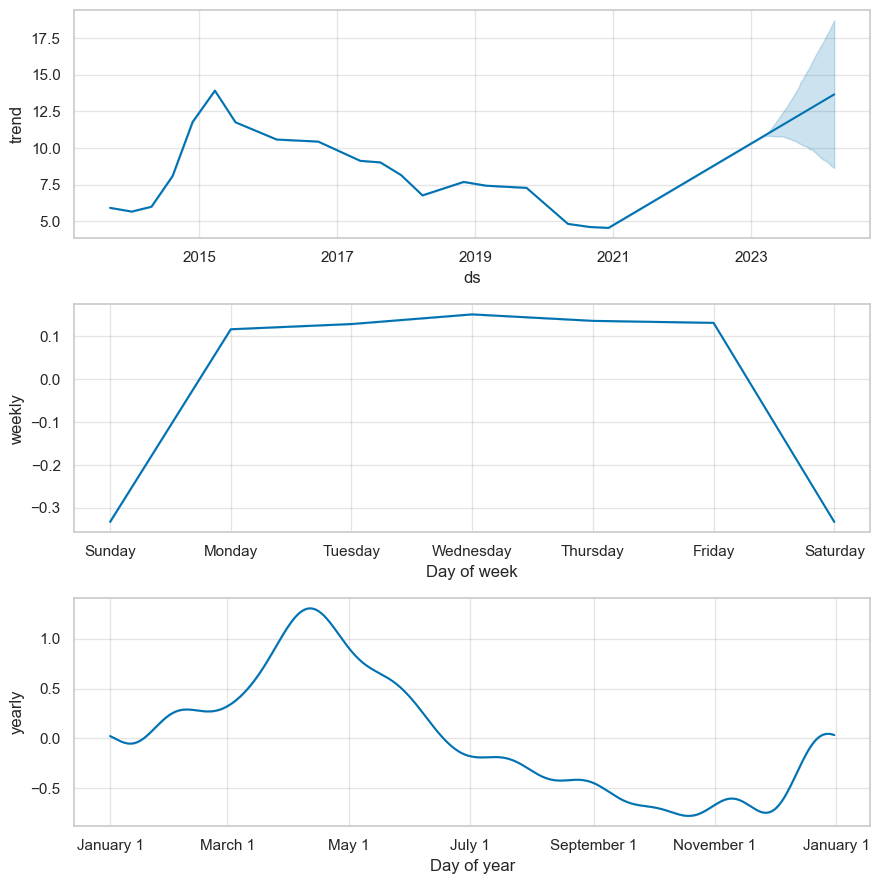

In [27]:
# Смотрим график прогноза, тренд, годовые и сезонные признаки после обучния на лучших параметрах
plot_forecast(final_test_model, forecast)

## Сравнение фактов и прогнозов

In [28]:
# Создание df с прогнозом
df_test_forecast_final = final_test_model.predict(df_test)
df_test_forecast_final[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
406,2024-09-09,14.585063,5.712227,23.175998
407,2024-09-10,14.591847,5.633606,23.504527
408,2024-09-11,14.609169,5.651154,23.135870
409,2024-09-12,14.589336,5.785867,23.424433
410,2024-09-13,14.580414,5.476605,23.359400


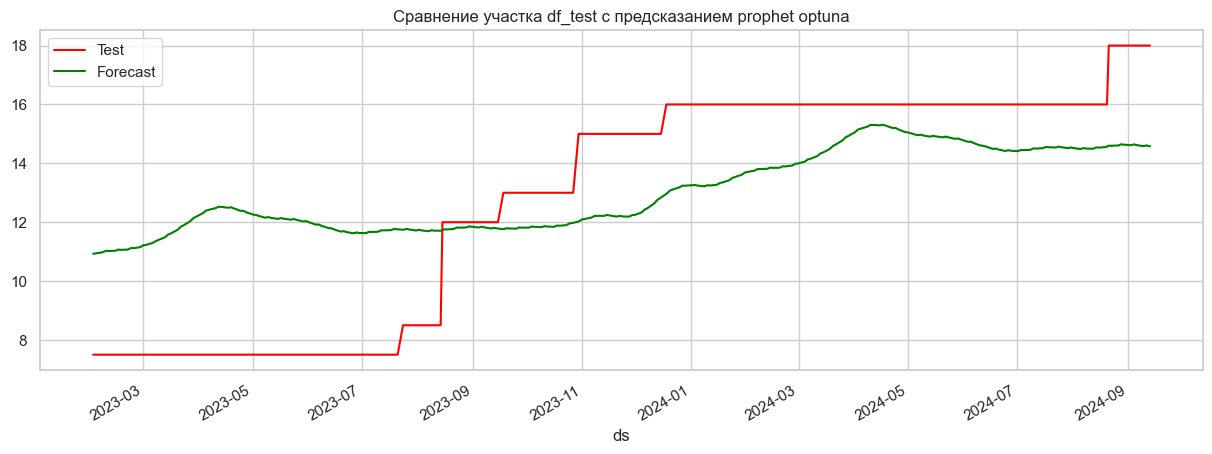

In [29]:
# Сравнение участка df_test с предсказанием prophet optuna
fig, ax = plt.subplots(figsize=(14,5))
fig.set_figheight(5)
fig.set_figwidth(15)
df_test.plot(kind='line',x='ds', y='y', color='red', label='Test', ax=ax)
df_test_forecast_final.plot(kind='line',x='ds',y='yhat', color='green',label='Forecast', ax=ax)
plt.title('Сравнение участка df_test с предсказанием prophet optuna')
plt.show()

In [30]:
# Сравниваем метрики после добавления в модель праздников 
metrics = pd.concat([metrics, get_metrics(y_test=df_test['y'], y_pred=df_test_forecast_final['yhat'], name='Prophet_best_params_optuna')])
metrics

,model,MAE,MAPE_%,MSE,RMSE
0,Prophet_baseline,2.632240,0.253425,8.240264,2.870586
0,Prophet_with_holidays,2.638834,0.253672,8.267269,2.875286
0,Prophet_best_params_optuna,2.517165,0.253142,8.297462,2.880531


In [31]:
# # Сохранение метрик
# with open(metrics_path, 'w') as f:
#     json.dump(metrics, f)

In [32]:
# Добавляем столбец в metrics с текущей датой и временем
metrics['date'] = datetime.now().strftime('%Y-%m-%d %H:%M:%S')

In [33]:
# Сохранение метрик
metrics.to_json(metrics_path, orient='records', lines=True, mode='a')

# Обучение и прогнозирование курса ставки рефинансирования ЦБ РФ на полных данных с пронозированием на будущий период

# Prophet baseline on df

In [34]:
# Обучение модели на df
prophet_bl = train_model(df)

In [35]:
# Создание df с прогнозом
forecast_bl = generate_forecast(prophet_bl, pred_days_forecast)

c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


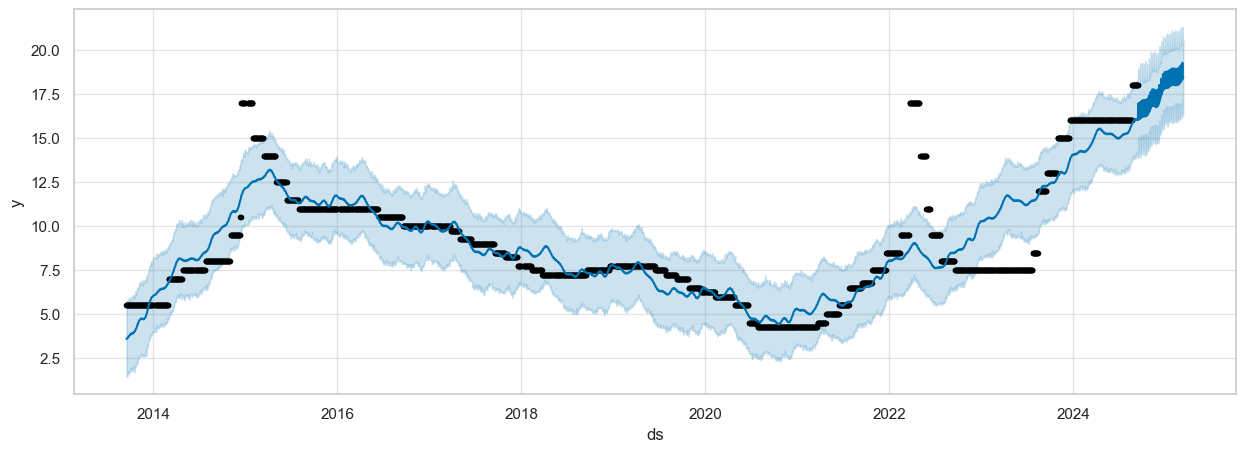

c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series cont

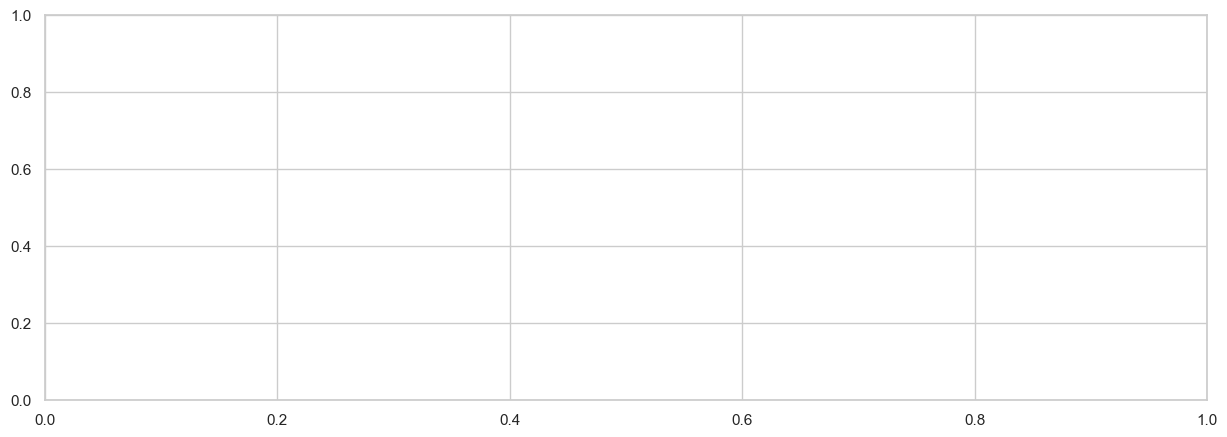

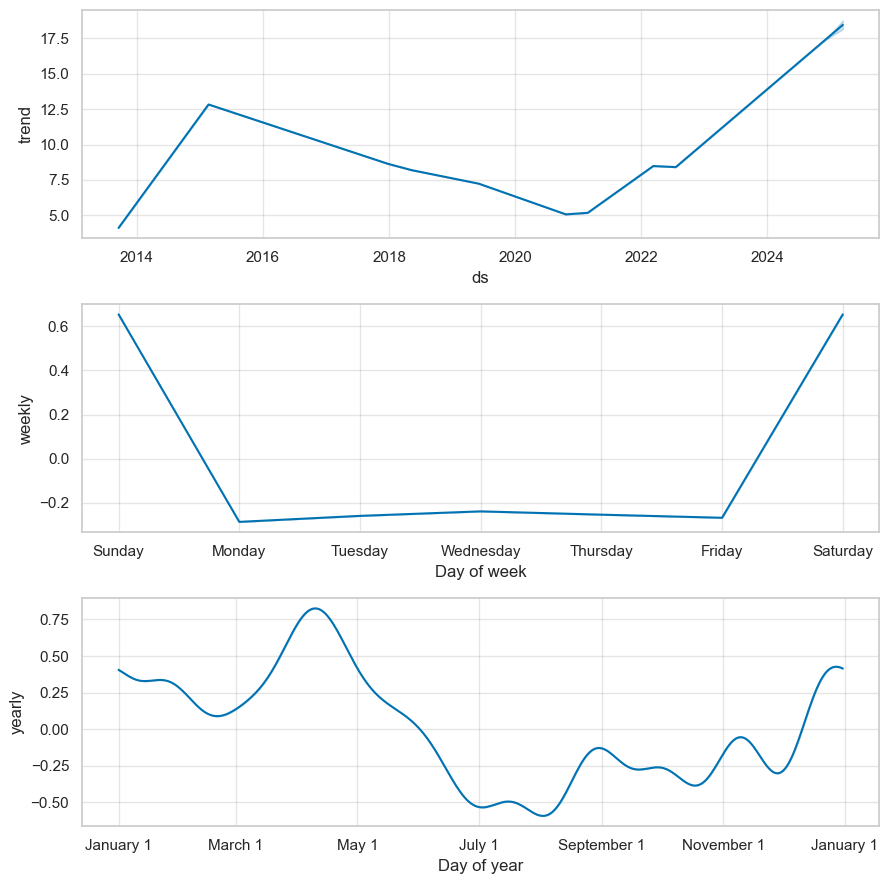

In [36]:
# Смотрим график прогноза, тренд, годовые и сезонные признаки после обучния на лучших параметрах
plot_forecast(prophet_bl, forecast_bl)

# Prophet best params on df

In [37]:
# Обучение модели с лучшими параметрами на df
final_test_model = train_model(df, **prophet_best_params)

In [38]:
# Создание df с прогнозом
forecast_ftm = generate_forecast(final_test_model, pred_days_forecast)

c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


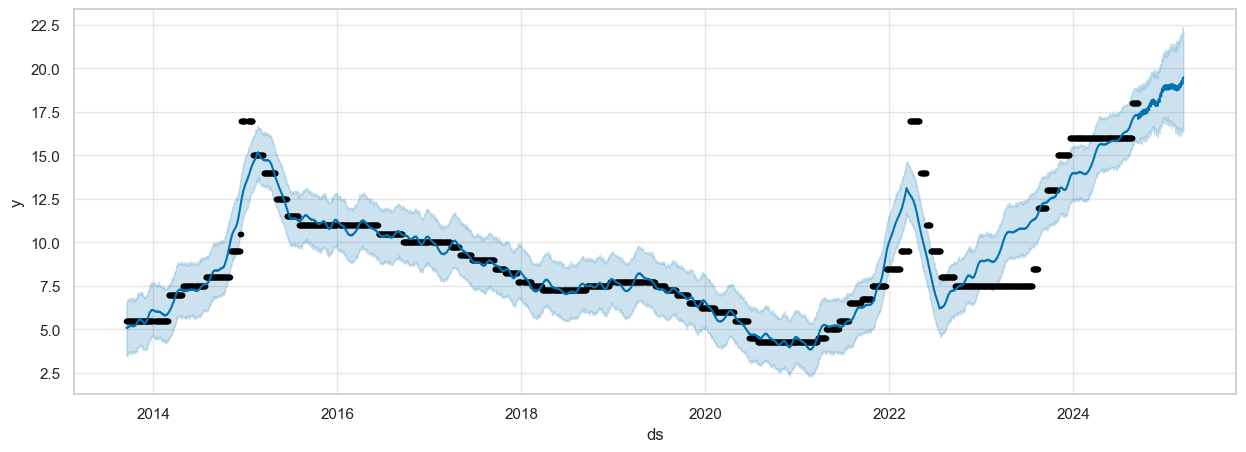

c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series cont

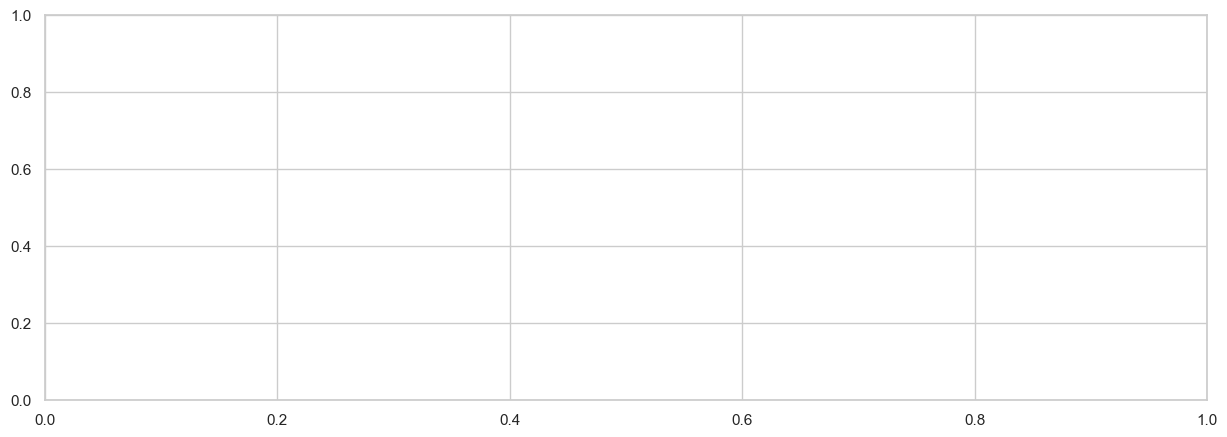

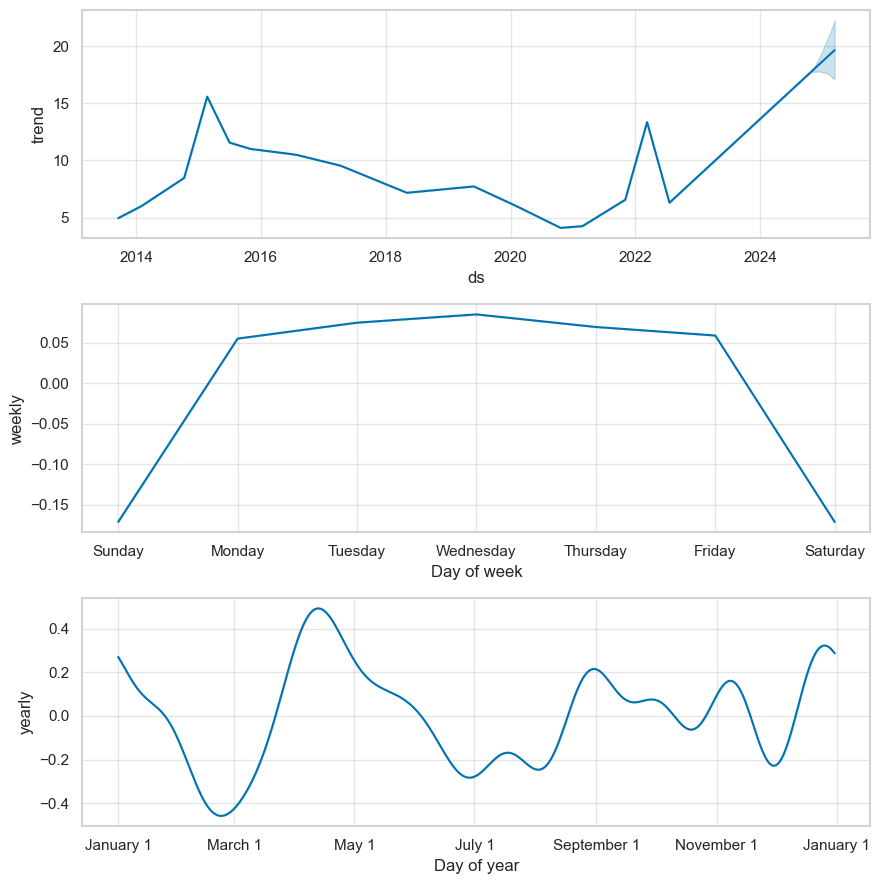

In [39]:
# Смотрим график прогноза, тренд, годовые и сезонные признаки после обучния на лучших параметрах
plot_forecast(final_test_model, forecast_ftm)

# Сравнение прогнозов обученных моделей

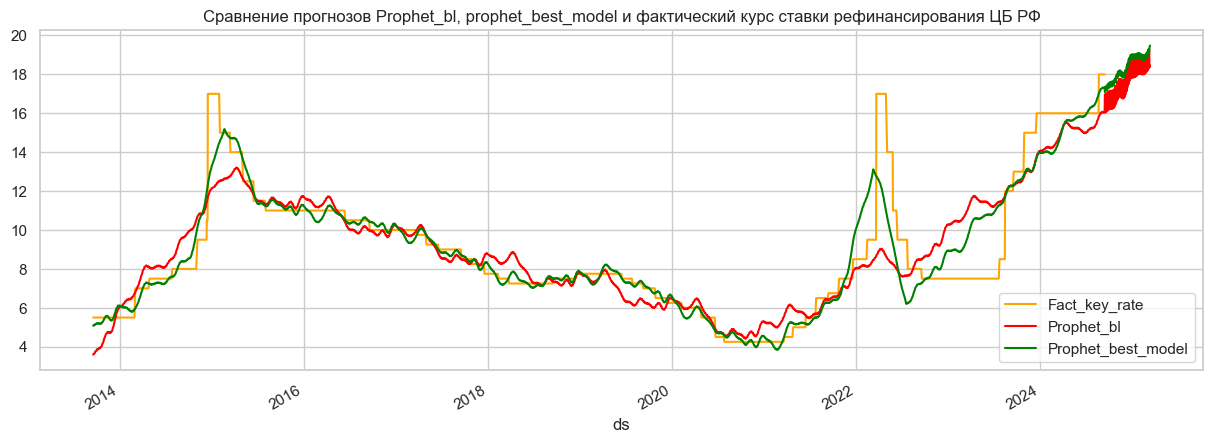

In [40]:
# Сравнение прогнозов Prophet_bl, prophet_best_model и фактический курс ставки рефинансирования ЦБ РФ
fig, ax = plt.subplots(figsize=(14,5))
fig.set_figheight(5)
fig.set_figwidth(15)
df.plot(kind='line',x='ds', y='y', color='orange', label='Fact_key_rate', ax=ax)
forecast_bl.plot(kind='line', x='ds', y='yhat', color='red', label='Prophet_bl', ax=ax)
forecast_ftm.plot(kind='line', x='ds', y='yhat', color='green', label='Prophet_best_model', ax=ax)
plt.title('Сравнение прогнозов Prophet_bl, prophet_best_model и фактический курс ставки рефинансирования ЦБ РФ')
plt.show()

In [41]:
# Вычисление последней даты в df
last_date = df['ds'].max()

# Создание df с курсами ставки рефинансирования, фактический курс, прогноз бейзлайна, прогноз с лучшими параметрами
key_rate = pd.DataFrame({
    'date': [last_date],
    'fact': [df.loc[df['ds'] == last_date, 'y'].iloc[0]],
    'baseline': [forecast_bl.loc[forecast_bl['ds'] == last_date, 'yhat'].iloc[0]],
    'best_params': [forecast_ftm.loc[forecast_ftm['ds'] == last_date, 'yhat'].iloc[0]]
})

# Отображение df
key_rate

,date,fact,baseline,best_params
0,2024-09-13,18.0,16.048093,17.320021
